In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'itba-cifar-100-2024-q-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77584%2F8490010%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T195840Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5aa4a23fe6d8d61fe92835b44aa4bab31069c7ce152ee23a6d8819e17bc8d0c7215e6b4ca6e7ca65e938ddfa9e130e5c4bd0e5152a91d1b39bfc5239368e691de60707e34770481e571d64d4d6617dd7a9e6aa114165f6537f5922be9c920d48fb5e8a53e76df5160d2a9f6d3376f2b26102561d2ea3bd3bf75a71090ca3611ca4a80dbd080f13249b694861c0378850c0ed51362cb225cbcff4ab26e31e66866a033817f3b8c1f0b8a3cb5a1e9b8dc0c4315f3b66c57bf55a9eccb62cab0707c778f39d763eaa851c65a20907cac723b5d3da10a2c1d538e67e077af27f878d34190726712571d5973e02d2e4616c2339327ab69d00b7aa6c62766dc15413f4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 168426762 bytes downloaded
Downloaded and uncompressed: itba-cifar-100-2024-q-1
Data source import complete.


#Inicialización y EDA


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck


In [3]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")
print(y_train_coarse)
print(y_train_fine)


[11 15  4 ...  8  7  1]
[19 29  0 ...  3  7 73]


In [4]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [5]:
from matplotlib import pyplot as plt
#%load_ext tensorboard

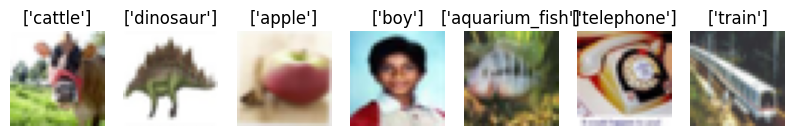

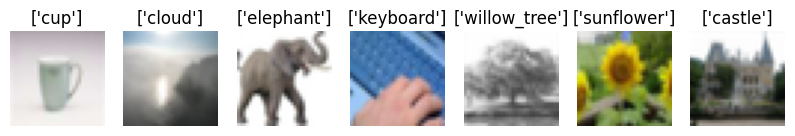

In [6]:

plt.figure(figsize=(10, 10))
cant = 7
for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train[i ])
    plt.title([labels_fine[y_train_fine[i]]])
    plt.axis('off')

plt.show()
plt.figure(figsize=(10, 10))

for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train[i +cant ])
    plt.title([labels_fine[y_train_fine[i+ cant]]])
    plt.axis('off')


##Cross validation


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_train_cv, y_train, y_train_cv = train_test_split(np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.,
                                                    y_train_fine, test_size=0.2, random_state=42)

In [8]:
print(len(X_train))
print(len(X_train_cv))
print(len(y_train))
print(len(y_train_cv))

40000
10000
40000
10000


#Data Augmentation


Se realizó un data augmentation tomando un parte del dataset (si se toman todas las imágenes necesitamos mucho recursos de computación y tiempo). En este caso se tomaron 5000 imágenes y se les aplicó RandomCutOut.

Se intentó también cambiar otra cantidad de impagenes con otros métodos, pero no se generaron muchos cambios en la performance de la red.





In [9]:
pip install keras-cv-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.9/650.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.6 MB/s eta 0:00:00


In [11]:
import keras_cv


Using TensorFlow backend


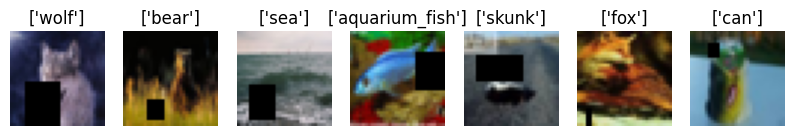

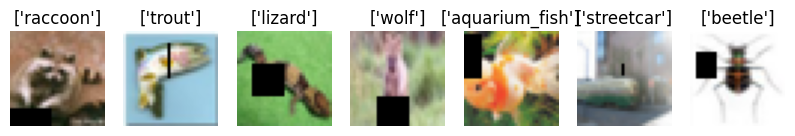

In [87]:
random_cutout = keras_cv.layers.RandomCutout(0.5,0.5)
x_train_cutout = random_cutout(X_train[:6000])
y_train_cuout = y_train[:6000]

plt.figure(figsize=(10, 10))
cant = 7
for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train_cutout[i ])
    plt.title([labels_fine[y_train_cuout[i]]])
    plt.axis('off')

plt.show()
plt.figure(figsize=(10, 10))

for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train_cutout[i +cant ])
    plt.title([labels_fine[y_train_cuout[i+ cant]]])
    plt.axis('off')
plt.show()


In [55]:
grid_mask = keras_cv.layers.GridMask(seed=22)
x_train_grid_mask = grid_mask(X_train[500:1000])
y_train_grid_mask = y_train[500:1000]
plt.figure(figsize=(10, 10))
cant = 7
for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train_grid_mask[i])
    plt.title([labels_fine[y_train_grid_mask[i]]])
    plt.axis('off')

plt.show()

plt.figure(figsize=(10, 10))
for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train_grid_mask[i +cant  ])
    plt.title([labels_fine[y_train_grid_mask[i+ cant]]])
    plt.axis('off')
plt.show()


KeyboardInterrupt: 

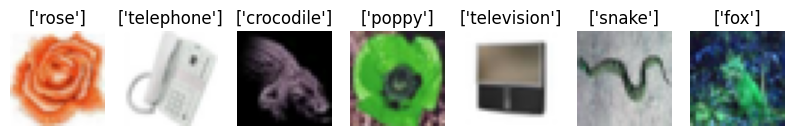

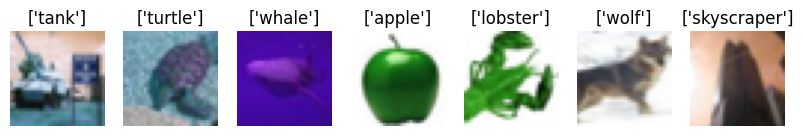

In [14]:

channel_shuffle = keras_cv.layers.ChannelShuffle(seed=22)
x_train_channel_shuffle = channel_shuffle(X_train[1000:1500])
y_train_channel_shuffle = y_train[1000:1500]
plt.figure(figsize=(10, 10))
cant = 7
for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train_channel_shuffle[i])
    plt.title([labels_fine[y_train_channel_shuffle[i]]])
    plt.axis('off')

plt.show()
plt.figure(figsize=(10, 10))

for i in range(cant):
    plt.subplot(1, cant, i + 1)
    plt.imshow(x_train_channel_shuffle[i +cant  ])
    plt.title([labels_fine[y_train_channel_shuffle[i+ cant]]])
    plt.axis('off')
plt.show()


In [88]:
import numpy as np
X_train_final = np.concatenate([X_train,  x_train_cutout,  ])
Y_train_final = np.concatenate([ y_train, y_train_cuout,])
print(len(X_train_final))


46000


#Modelo de la red CNN


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,Activation, SpatialDropout2D, SpatialDropout1D, GaussianNoise
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, RandomNormal, Constant
from tensorflow.keras.optimizers.schedules import InverseTimeDecay


In [90]:
#Se requiere extender el dataset, se utiliza un generator donde se rotan las imagnes y se obtiene
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=24,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.4,
)
datagen.fit(X_train_final)

In [91]:
#X_train_flip.shape
#plt.figure(figsize=(1,1))
#plt.imshow(x_train[50000])

In [92]:
model = Sequential()
#Kernel initialiazer
initializer = GlorotUniform()
#First convolution
model.add(Conv2D(128, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
model.add(MaxPooling2D((2, 2)))


#Second convolution
model.add(Conv2D(256, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
# model.add(Dropout(0.2)) #Agregado
model.add(Conv2D(256, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
model.add(BatchNormalization())#Agregado
model.add(MaxPooling2D((2, 2)))

model.add(GaussianNoise(0.1))
#Third convolution
model.add(Conv2D(512, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
#model.add(Dropout(0.2)) #Agregado
model.add(Conv2D(512, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
model.add(BatchNormalization())#Agregado
model.add(MaxPooling2D((2, 2)))


# model.add(GaussianNoise(0.1))

# #Third convolution
# model.add(Conv2D(1024, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
# #model.add(Dropout(0.2)) #Agregado
# model.add(Conv2D(1024, kernel_size= (3, 3) , input_shape=(32,32,3), activation = 'swish', padding= 'same'))
# model.add(BatchNormalization())#Agregado
# model.add(MaxPooling2D((2, 2)))



model.add(Flatten(input_shape=(32,32,3)))

#First layer
model.add(Dense(1024, activation="swish", kernel_initializer = initializer, kernel_constraint=MaxNorm(4)))
model.add(Dropout(0.2))
#model.add(BatchNormalization())


#second layer
model.add(Dense(512, activation="swish", kernel_initializer = initializer))
#model.add(Dropout(0.25))
model.add(BatchNormalization())

#thrid layer
model.add(Dense(256, activation="swish", kernel_initializer = initializer, kernel_constraint  =MaxNorm(4)))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

#fourth layer
model.add(Dense(100, activation="softmax",kernel_initializer = initializer))

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/while_loop.py", line 488, in while_loop
    loop_vars = body(*loop_vars)  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/map_fn.py", line 495, in compute
    return (i + 1, tas)  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/map_fn.py", line 492, in <listcomp>
    tas = [  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


In [93]:
# lr_schedule =InverseTimeDecay(
#     0.001,
#     decay_steps=1875*100,
#     decay_rate=5,
#     staircase=False
# )



rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.25,
    patience = 3,
    verbose = 1,
    min_lr = 0.5e-5
)

In [94]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_25 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 256)      

#Entrenamiento


In [95]:
mc = ModelCheckpoint(
    "best.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [96]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8,
    verbose = 1,
    restore_best_weights = True,
)

In [97]:
tb = TensorBoard(
    log_dir="logs",
)


In [98]:
history = model.fit(
#     x = X_train_flip,
#     y= Y_train_fine_flip,
    datagen.flow(X_train_final, Y_train_final, batch_size=64),
    batch_size=64,
    epochs=200,
    validation_data =(X_train_cv, y_train_cv),
    callbacks= [
        rlrop,
        es,
        mc,
        tb,
    ]
)

Epoch 1/200
719/719 [==============================] - ETA: 0s - loss: 3.9455 - accuracy: 0.0993
Epoch 1: val_accuracy improved from -inf to 0.13030, saving model to best.weights.h5
719/719 [==============================] - 57s 72ms/step - loss: 3.9455 - accuracy: 0.0993 - val_loss: 3.7983 - val_accuracy: 0.1303 - lr: 0.0010
Epoch 2/200
718/719 [============================>.] - ETA: 0s - loss: 3.2942 - accuracy: 0.1993
Epoch 2: val_accuracy improved from 0.13030 to 0.17770, saving model to best.weights.h5
719/719 [==============================] - 58s 81ms/step - loss: 3.2936 - accuracy: 0.1993 - val_loss: 3.4896 - val_accuracy: 0.1777 - lr: 0.0010
Epoch 3/200
719/719 [==============================] - ETA: 0s - loss: 2.8947 - accuracy: 0.2719
Epoch 3: val_accuracy improved from 0.17770 to 0.30540, saving model to best.weights.h5
719/719 [==============================] - 61s 84ms/step - loss: 2.8947 - accuracy: 0.2719 - val_loss: 2.6886 - val_accuracy: 0.3054 - lr: 0.0010
Epoch 4/20

#Resultados


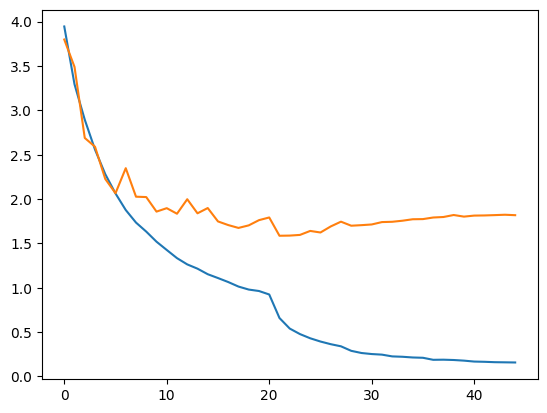

In [99]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

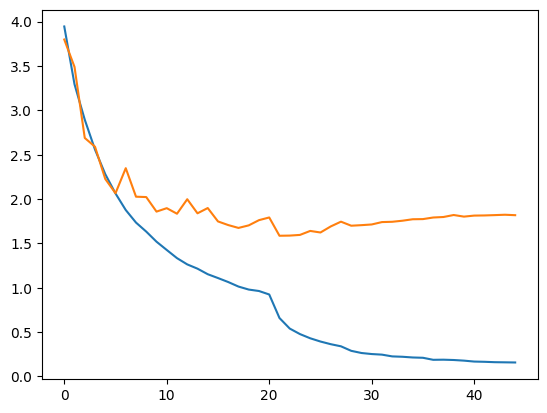

In [101]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

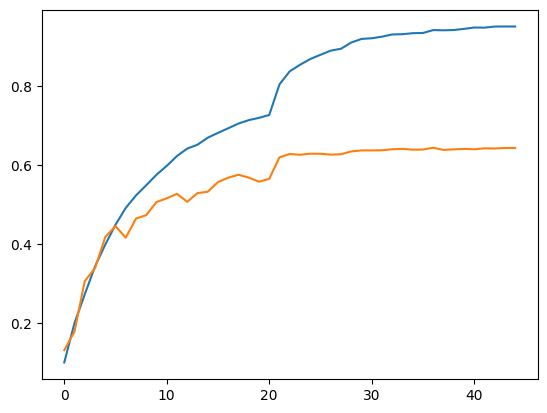

In [100]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

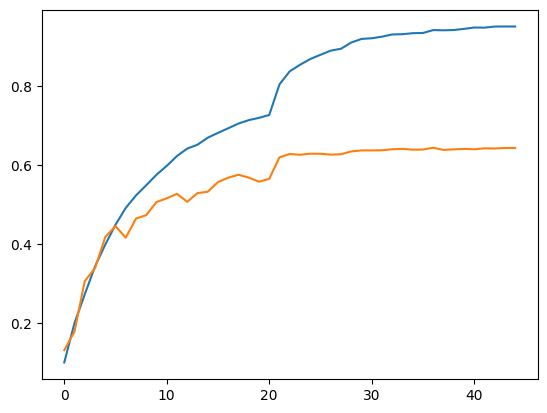

In [102]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [103]:
predictions = model.predict(x_test)

#test_accuracy_prom=sum(np.array(predictions)==np.array(x_test[\"target\"]))/len(twenty_test[\"target\"])*100\n))

313/313 [==============================] - 3s 8ms/step


In [104]:
predictions = predictions.argmax(axis=1)

In [105]:
predictions

array([46, 33, 93, ..., 51, 42, 70])

In [106]:
df = pd.DataFrame(predictions, columns=["Label"])

In [107]:
df.index.name = "Id"

In [108]:
df.head()

,Label
Id,
0,46
1,33
2,93
3,51
4,71


In [109]:
df.to_csv("submission.csv")